In [1]:
%matplotlib inline

import pandas as pd

from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import numpy as np

In [2]:
df = pd.read_csv('data/btc_1h_train.csv')
df.drop(['open', 'high', 'low', 'close'], axis=1, inplace=True)

In [3]:
y = df.filter(like = 'target')
X = df.drop(y.columns, axis=1)
X = X.drop('datetime', axis=1)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X = pd.DataFrame(X_normalized, columns=X.columns)
y = pd.DataFrame(y, columns=y.columns)

In [4]:
X.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22164 entries, 0 to 22163
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   volume           22164 non-null  float64
 1   close_vol        22164 non-null  float64
 2   RSI              22164 non-null  float64
 3   exp_RSI          22164 non-null  float64
 4   bb_high          22164 non-null  float64
 5   bb_low           22164 non-null  float64
 6   atr              22164 non-null  float64
 7   macd             22164 non-null  float64
 8   signal           22164 non-null  float64
 9   macd_signal      22164 non-null  float64
 10  OBV              22164 non-null  float64
 11  EMA              22164 non-null  float64
 12  EMA_Slope        22164 non-null  float64
 13  vwap             22164 non-null  float64
 14  return_1d        22164 non-null  float64
 15  return_4d        22164 non-null  float64
 16  return_12d       22164 non-null  float64
 17  return_24d  

In [42]:
model = Ridge(alpha=0.1)
look_back = 2880
pred_window = 120
target_k = 1
y_pred = []
y_actual = []
for i in range(look_back, len(X) - pred_window, pred_window):
    model.fit(X[i-look_back:i-target_k], y[i-look_back:i-target_k][f'target_{target_k}d'])
    y_pred = y_pred + model.predict(X[i:i+pred_window]).tolist()
    y_actual = y_actual + y[i:i+pred_window][f'target_{target_k}d'].tolist()

In [43]:
cut = 1.5
y_pred = np.array(y_pred)
y_actual = np.array(y_actual)
count_greater = ((y_actual > cut) & (y_pred > cut)).sum()
count_less = ((y_actual < -cut) & (y_pred < -cut)).sum()
total_samples = len(y_actual)

percentage_greater = (count_greater / total_samples) * 100
percentage_less = (count_less / total_samples) * 100

count_pred_greater = (y_pred > cut).sum()
count_pred_less = (y_pred < -cut).sum()
percentage_pred_greater = (count_pred_greater / total_samples) * 100
percentage_pred_less = (count_pred_less / total_samples) * 100

count_actual_greater = (y_actual > cut).sum()
count_actual_less = (y_actual < -cut).sum()
percentage_actual_greater = (count_actual_greater / total_samples) * 100
percentage_actual_less = (count_actual_less / total_samples) * 100

count_condition = ((y_pred > cut) & (y_actual > 0) | (y_pred < -cut) & (y_actual < 0)).sum()


print(f"Percentage of times y_pred > or < {cut} and y_actual has same sign: {count_condition/(count_pred_greater + count_pred_less) * 100}")
print(f"Percentage of times y_pred was greater than {cut} or less than -{cut}: {percentage_pred_greater + percentage_pred_less}%")
print(f"Percentage of times y_actual was greater than {cut} or less than -{cut}: {percentage_actual_greater + percentage_actual_less}%")
print(f"Percentage of times both y_actual and y_pred were greater than {cut} or less than -{cut}: {percentage_greater + percentage_less}%")



Percentage of times y_pred > or < 1.5 and y_actual has same sign: 53.068043742405834
Percentage of times y_pred was greater than 1.5 or less than -1.5: 17.145833333333336%
Percentage of times y_actual was greater than 1.5 or less than -1.5: 65.53125%
Percentage of times both y_actual and y_pred were greater than 1.5 or less than -1.5: 7.28125%


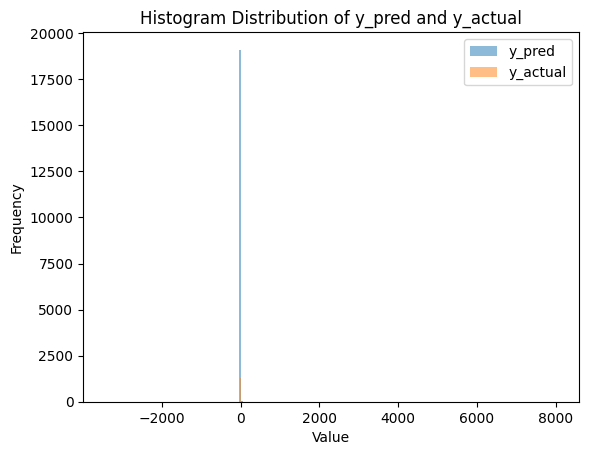

In [37]:
plt.hist(y_pred, bins=200, alpha=0.5, label='y_pred')
plt.hist(y_actual, bins=200, alpha=0.5, label='y_actual')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Distribution of y_pred and y_actual')
plt.legend()
plt.show()